In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import powerlaw
from operator import itemgetter
%matplotlib inline

In [3]:
def compute_spike_count(X):
    """
    Args:
        X: (np.array): spike train

    Returns:

    """
    return np.sum(X, axis=1)


def compute_avalanche(X: np.array, threshold=None):
    """Avalanche sizes, durations and interval sizes

        - Set the neural activity =0 if < activity_threshold
        - Slice the array by non-zero value indices
        - Count the number of items in each slices: Duration of avalanches
        - Sum the items in each slices: Size of avalanches
        - Slice the array into zero value indices
        - Count number of items in each slices: Duration of inter avalanche intervals

    Args:
        X (np.array): spike train

        threshold (int, optional): Threshold of number of spikes at each time step. Spike counts below threshold will be set to zero.Defaults to 1.
    Returns:
        spike_count (np.array): Number of spikes at each time step

        avalanche_durations (np.array): Avalanches durations

        avalanche_sizes (np.array): Number of spikes within each avalanche duration

        iai (np.array): Time interval between avalanches
    """

    spike_count = np.asarray(compute_spike_count(X))
    if threshold is None:
        threshold = np.median(spike_count) / 2
    spike_count[spike_count < threshold] = 0

    # Avalanche size and duration
    # Get the non zero indices
    aval_idx = np.nonzero(spike_count)[0]

    # Group indices by a consecutiveness
    aval_indices = []
    for k, g in itertools.groupby(enumerate(aval_idx), lambda ix: ix[0] - ix[1]):
        aval_indices.append(list(map(itemgetter(1), g)))

    # Using group indices, pick the correpondning items in the spike_count list
    avalanches = []
    for val in aval_indices:
        avalanches.append(list(spike_count[val]))

    # Avalanche sizes
    avalanche_sizes = [sum(avalanche) for avalanche in avalanches]
    # Avalanche duration
    avalanche_durations = [len(avalanche) for avalanche in avalanches]

    # Inter avalanche intervals

    # Get the indices where spike count =0
    silent_idx = np.where(spike_count == 0)[0]

    silent_indices = []
    # Group indices by consecutiveness
    for k, g in itertools.groupby(enumerate(silent_idx), lambda ix: ix[0] - ix[1]):
        silent_indices.append(list(map(itemgetter(1), g)))
    iai_ = []
    for val in silent_indices:
        iai_.append(list(spike_count[val]))
    # Duration of inter-avalanche intervals
    iai = [len(intervals) for intervals in iai_]

    return spike_count, np.array(avalanche_sizes), np.array(avalanche_durations), np.array(iai)

# Critical Spike

Text(0.5, 0, 'time(ms)')

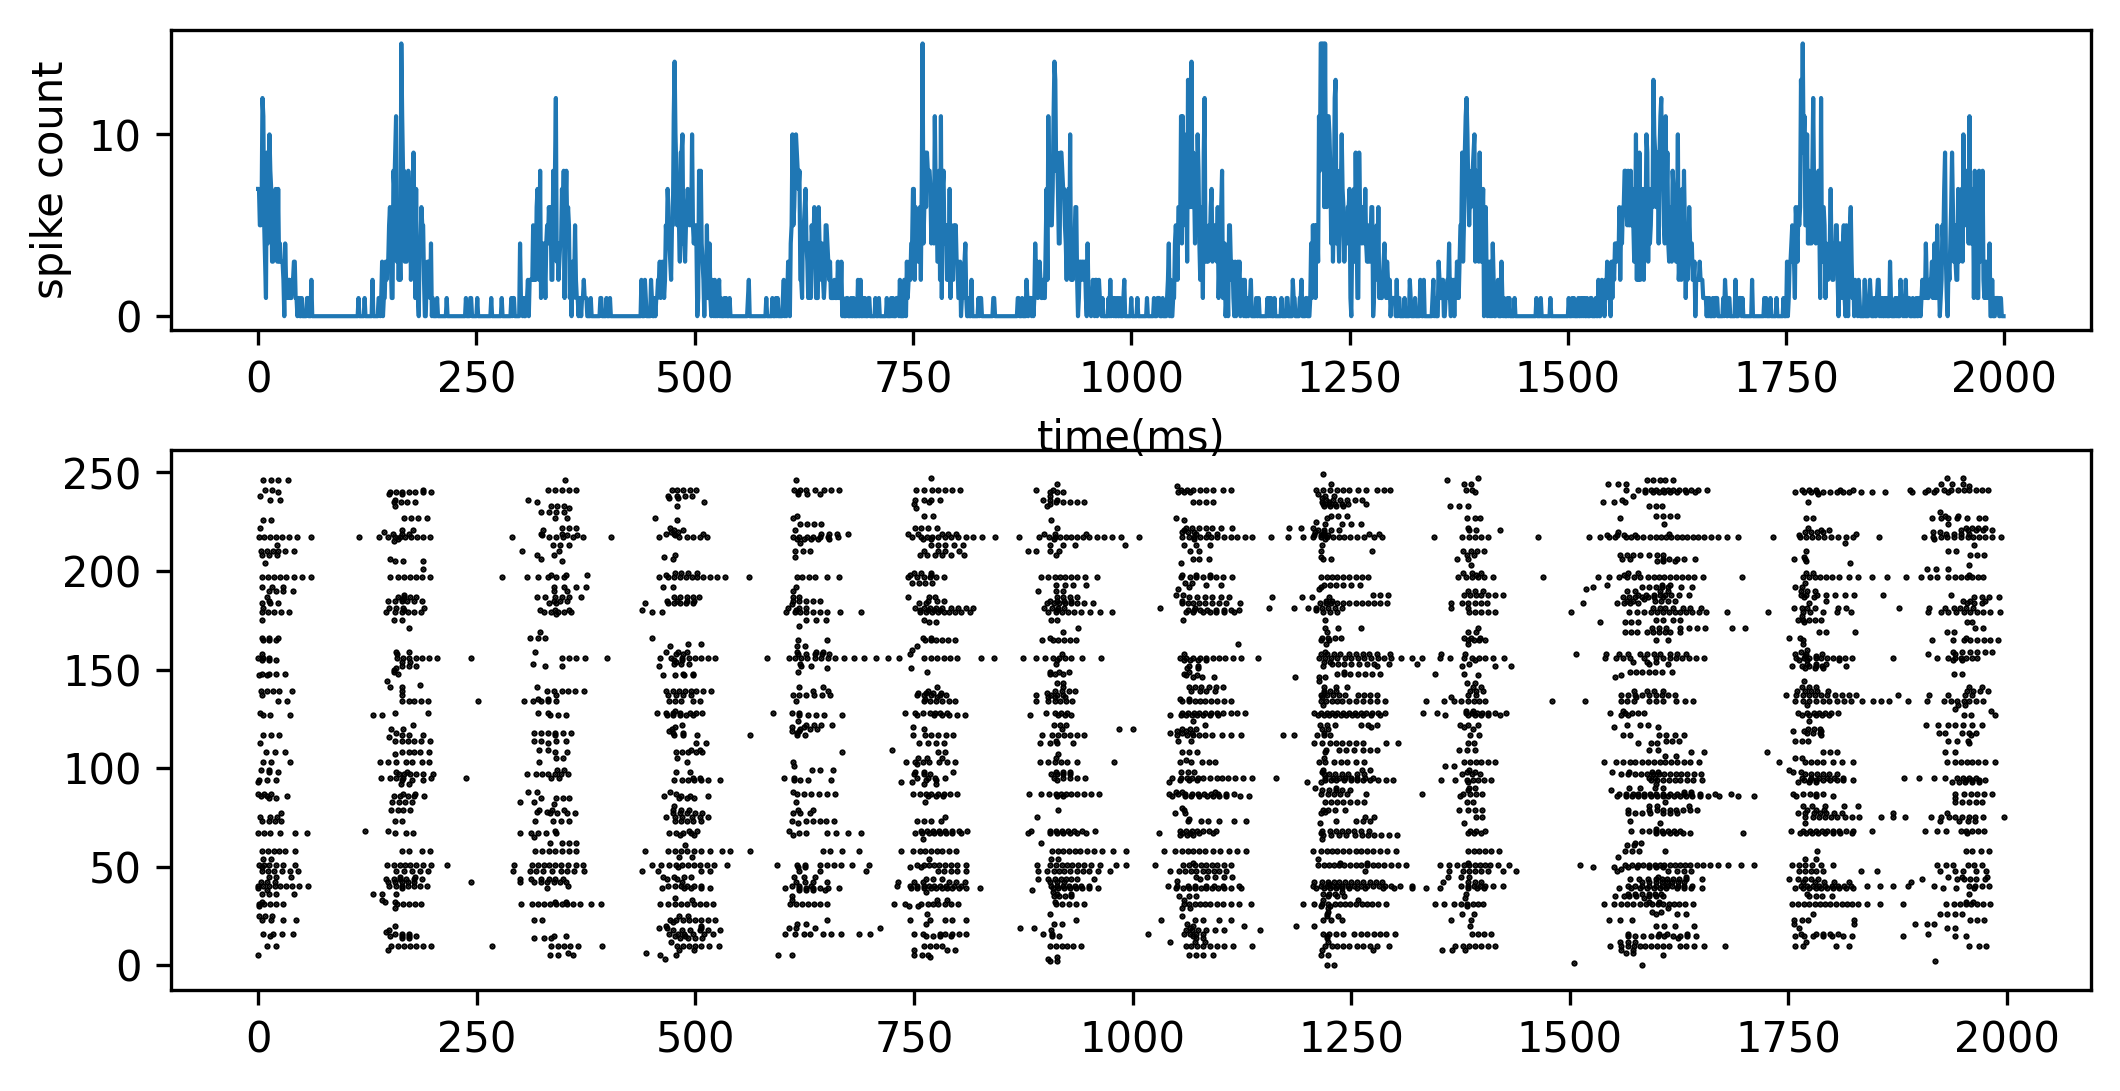

In [6]:
critical_spike = np.load("critical_spike.npy")
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.45])
ax.scatter(*critical_spike[-2000:, ].nonzero(), marker=".", c="k", s=1)
ax = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax.plot(np.sum(critical_spike[-2000:, ], axis=1), lw=1)
ax.set_ylabel("spike count")
ax.set_xlabel("time(ms)")

aval_size.shape (993,)
0.00024502417163453096


Text(0, 0.5, 'probablity')

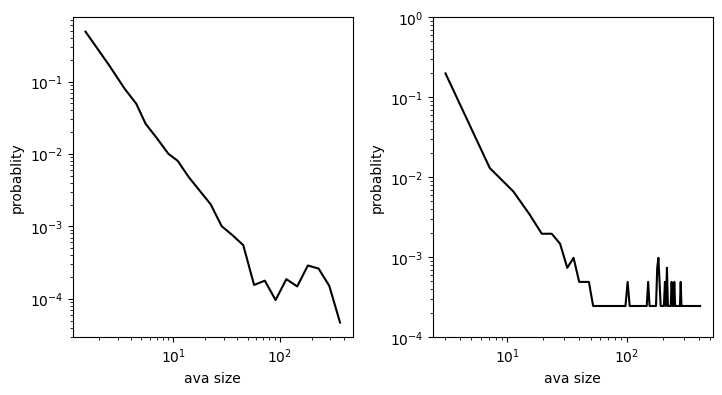

In [17]:
_, aval_size, aval_dur, _ = compute_avalanche(critical_spike[:, :200], None)
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_axes([0.1, 0.1, 0.35, 0.8])
fit = powerlaw.Fit(aval_size, xmin=aval_size.min(), xmax=aval_size.max())
fit.plot_pdf(ax=ax, original_data=False, color="k", lw=1.5)
ax.set_xlabel("ava size")
ax.set_ylabel("probablity")

print("aval_size.shape", aval_size.shape)
hist, edges = np.histogram(aval_size, bins=100, density=True)
nonzero_hist = hist[hist.nonzero()[0]]
nonzero_min = np.min(nonzero_hist)
print(nonzero_min)
hist = np.where(hist == 0, nonzero_min, hist)
ax = fig.add_axes([0.55, 0.1, 0.35, 0.8])
ax.plot((edges[1:] + edges[:-1]) / 2, hist, color="k", lw=1.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-4, 1])
ax.set_xlabel("ava size")
ax.set_ylabel("probablity")


# SubCritcial spike

torch.Size([2000, 22]) torch.Size([4, 2000, 2000])
log.max 1


Text(0.5, 0, 'time(ms)')

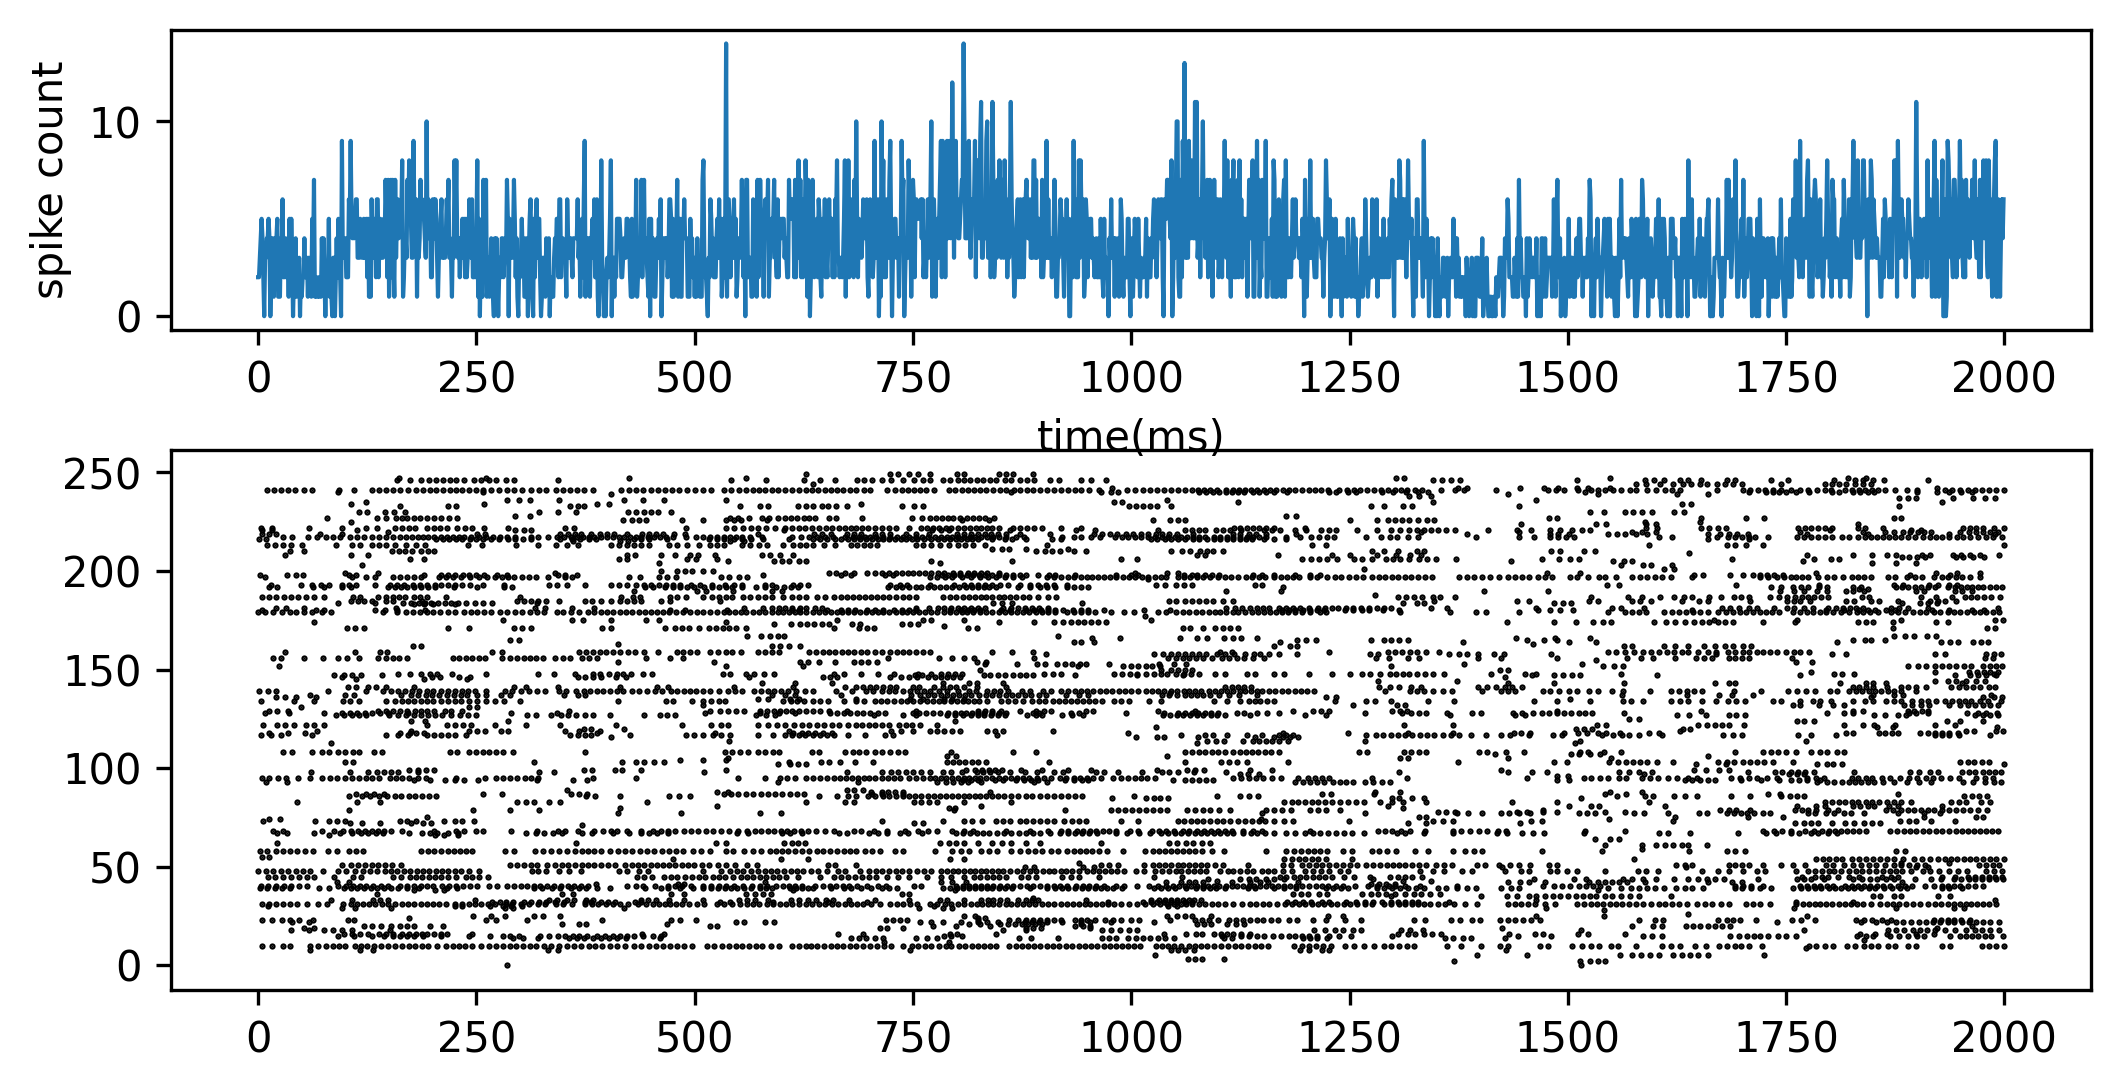

In [18]:
import torch
from brain_block.random_initialize import connect_for_block
from brain_block.block import block
from analysis.spike_statistics import instantaneous_rate
from scipy.ndimage import gaussian_filter1d
property, w_uij = connect_for_block("../data/small_block/small_block/single")
ampa_contribution = np.linspace(0.5, 1, num=100, endpoint=True)
gabaA_contribution = np.linspace(0., 0.5, num=100, endpoint=True)
contribution = np.stack(np.meshgrid(ampa_contribution, gabaA_contribution, indexing='ij'), axis=-1).reshape((-1, 2))
ampa_contribution = contribution[:, 0]
gabaA_contribution = contribution[:, 1]
ampa = ampa_contribution / 34
nmda = (1 - ampa_contribution) / 250
gabaA = gabaA_contribution / 2
gabaB = (1 - gabaA_contribution) / 36
para =np.stack([ampa, nmda, gabaA, gabaB], axis=1)
# specific_gui = para[60*100+80]
# print(specific_gui)
# property[:, (10, 11, 12, 13)] = specific_gui
# assign specific gui
property = property.cuda()
w_uij = w_uij.cuda()
B = block(
    node_property=property,
    w_uij=w_uij,
    delta_t=0.1,
)
log_all = []
synaptic_current = []
for time in range(100000):
    print(time, end='\r')
    B.run(noise_rate=0.0003, isolated=False)
    if time >= 10000:
        synaptic_current.append(B.I_ui[:, 1500].cpu().numpy())
        log_all.append(B.active.data.cpu().numpy())
synaptic_current = np.array(synaptic_current)
log_all = np.array(log_all, dtype=np.uint8)
log = log_all[:, 1400:1650]
log = log.reshape((-1, 10, 250))
log = log.sum(axis=1)
np.save("subcritical_spike.npy", log)
print("log.max", log.max())
# fr = instantaneous_rate(sub_log, bin_width=5)
# rate_time_series_auto_kernel = gaussian_filter1d(fr, 20, axis=-1)
torch.cuda.empty_cache()

fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.45])
ax.scatter(*log[-2000:, ].nonzero(), marker=".", c="k", s=1)
ax = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax.plot(np.sum(log[-2000:, ], axis=1), lw=1)
ax.set_ylabel("spike count")
ax.set_xlabel("time(ms)")

aval_size.shape (1379,)
0.00035899166421355516


Text(0, 0.5, 'probablity')

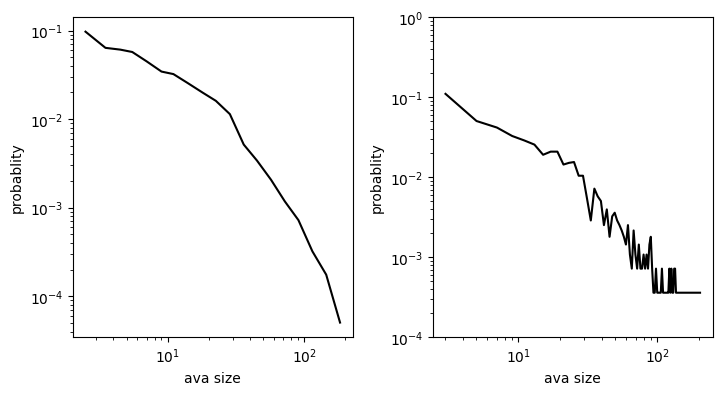

In [19]:
_, aval_size, aval_dur, _ = compute_avalanche(log[:, :200], None)
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_axes([0.1, 0.1, 0.35, 0.8])
fit = powerlaw.Fit(aval_size, xmin=aval_size.min(), xmax=aval_size.max())
fit.plot_pdf(ax=ax, original_data=False, color="k", lw=1.5)
ax.set_xlabel("ava size")
ax.set_ylabel("probablity")

print("aval_size.shape", aval_size.shape)
hist, edges = np.histogram(aval_size, bins=100, density=True)
nonzero_hist = hist[hist.nonzero()[0]]
nonzero_min = np.min(nonzero_hist)
print(nonzero_min)
hist = np.where(hist == 0, nonzero_min, hist)
ax = fig.add_axes([0.55, 0.1, 0.35, 0.8])
ax.plot((edges[1:] + edges[:-1]) / 2, hist, color="k", lw=1.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-4, 1])
ax.set_xlabel("ava size")
ax.set_ylabel("probablity")

# SuperCritical spike

threshold: 0.0
aval_size.shape (520,)
0.00028617216117216


Text(0, 0.5, 'probablity')

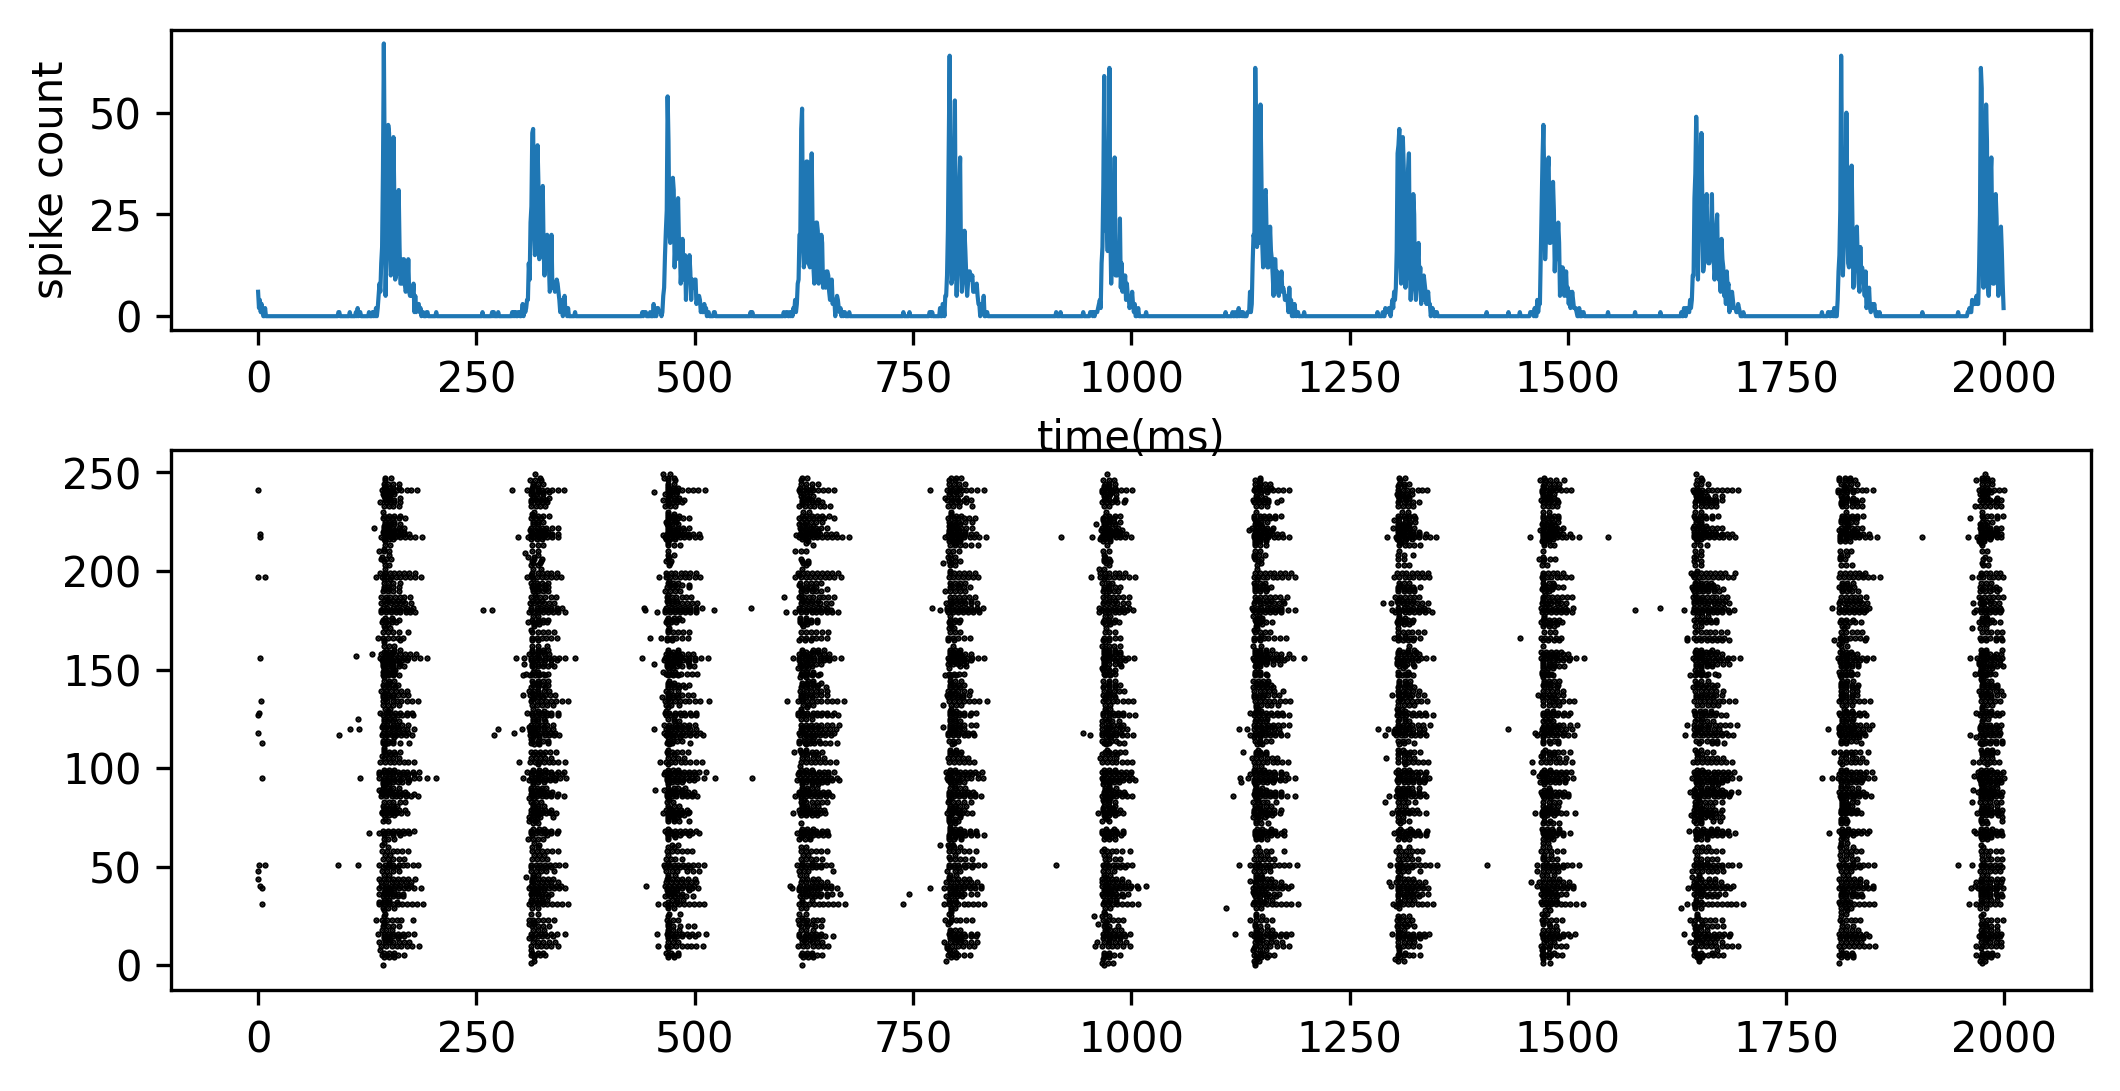

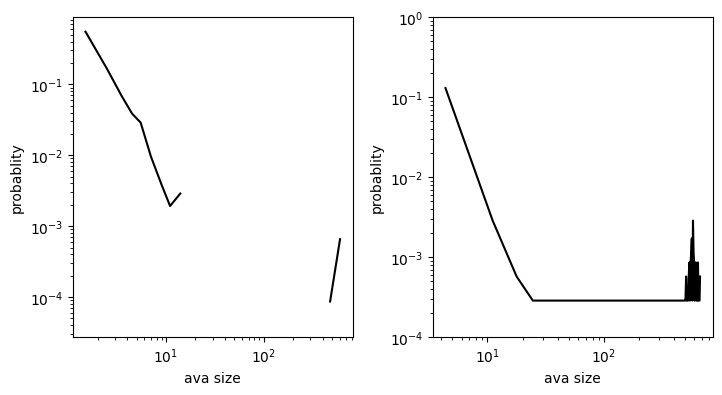

In [13]:
# import torch
# from brain_block.random_initialize import connect_for_block
# from brain_block.block import block
# ampa_contribution = np.linspace(0.5, 1, num=100, endpoint=True)
# gabaA_contribution = np.linspace(0., 0.5, num=100, endpoint=True)
# contribution = np.stack(np.meshgrid(ampa_contribution, gabaA_contribution, indexing='ij'), axis=-1).reshape((-1, 2))
# ampa_contribution = contribution[:, 0]
# gabaA_contribution = contribution[:, 1]
# ampa = ampa_contribution / 34
# nmda = (1 - ampa_contribution) / 250
# gabaA = gabaA_contribution / 2
# gabaB = (1 - gabaA_contribution) / 36
# para =np.stack([ampa, nmda, gabaA, gabaB], axis=1)
# specific_gui = para[75 * 100 + 55]
# property, w_uij = connect_for_block("../data/small_block/small_block/single")
# property[:, (10, 11, 12, 13)] = torch.from_numpy(specific_gui.astype(np.float32))
# property = property.cuda()
# w_uij = w_uij.cuda()
# B = block(
#     node_property=property,
#     w_uij=w_uij,
#     delta_t=0.1,
# )
# log_all = []
# for time in range(100000):
#     print(time, end='\r')
#     B.run(noise_rate=0.0003, isolated=False)
#     if time >= 10000:
#         log_all.append(B.active.data.cpu().numpy())
log_all = np.array(log_all, dtype=np.uint8)
log = log_all[:, 1400:1650]
log = log.reshape((-1, 10, 250))
log = log.sum(axis=1)
np.save("supercritical_spike.npy", log)
torch.cuda.empty_cache()

fig = plt.figure(figsize=(8, 4), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.45])
ax.scatter(*log[-2000:, ].nonzero(), marker=".", c="k", s=1)
ax = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax.plot(np.sum(log[-2000:, ], axis=1), lw=1)
ax.set_ylabel("spike count")
ax.set_xlabel("time(ms)")


_, aval_size, aval_dur, _ = compute_avalanche(log[:, :200], 1)
print("threshold:", np.median(np.sum(log[:, :200], axis=1)) / 2)
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_axes([0.1, 0.1, 0.35, 0.8])
fit = powerlaw.Fit(aval_size, xmin=aval_size.min(), xmax=aval_size.max())
fit.plot_pdf(ax=ax, original_data=False, color="k", lw=1.5)
ax.set_xlabel("ava size")
ax.set_ylabel("probablity")

print("aval_size.shape", aval_size.shape)
hist, edges = np.histogram(aval_size, bins=100, density=True)
nonzero_hist = hist[hist.nonzero()[0]]
nonzero_min = np.min(nonzero_hist)
print(nonzero_min)
hist = np.where(hist == 0, nonzero_min, hist)
ax = fig.add_axes([0.55, 0.1, 0.35, 0.8])
ax.plot((edges[1:] + edges[:-1]) / 2, hist, color="k", lw=1.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-4, 1])
ax.set_xlabel("ava size")
ax.set_ylabel("probablity")

# abstrcat

threshold, 0.0


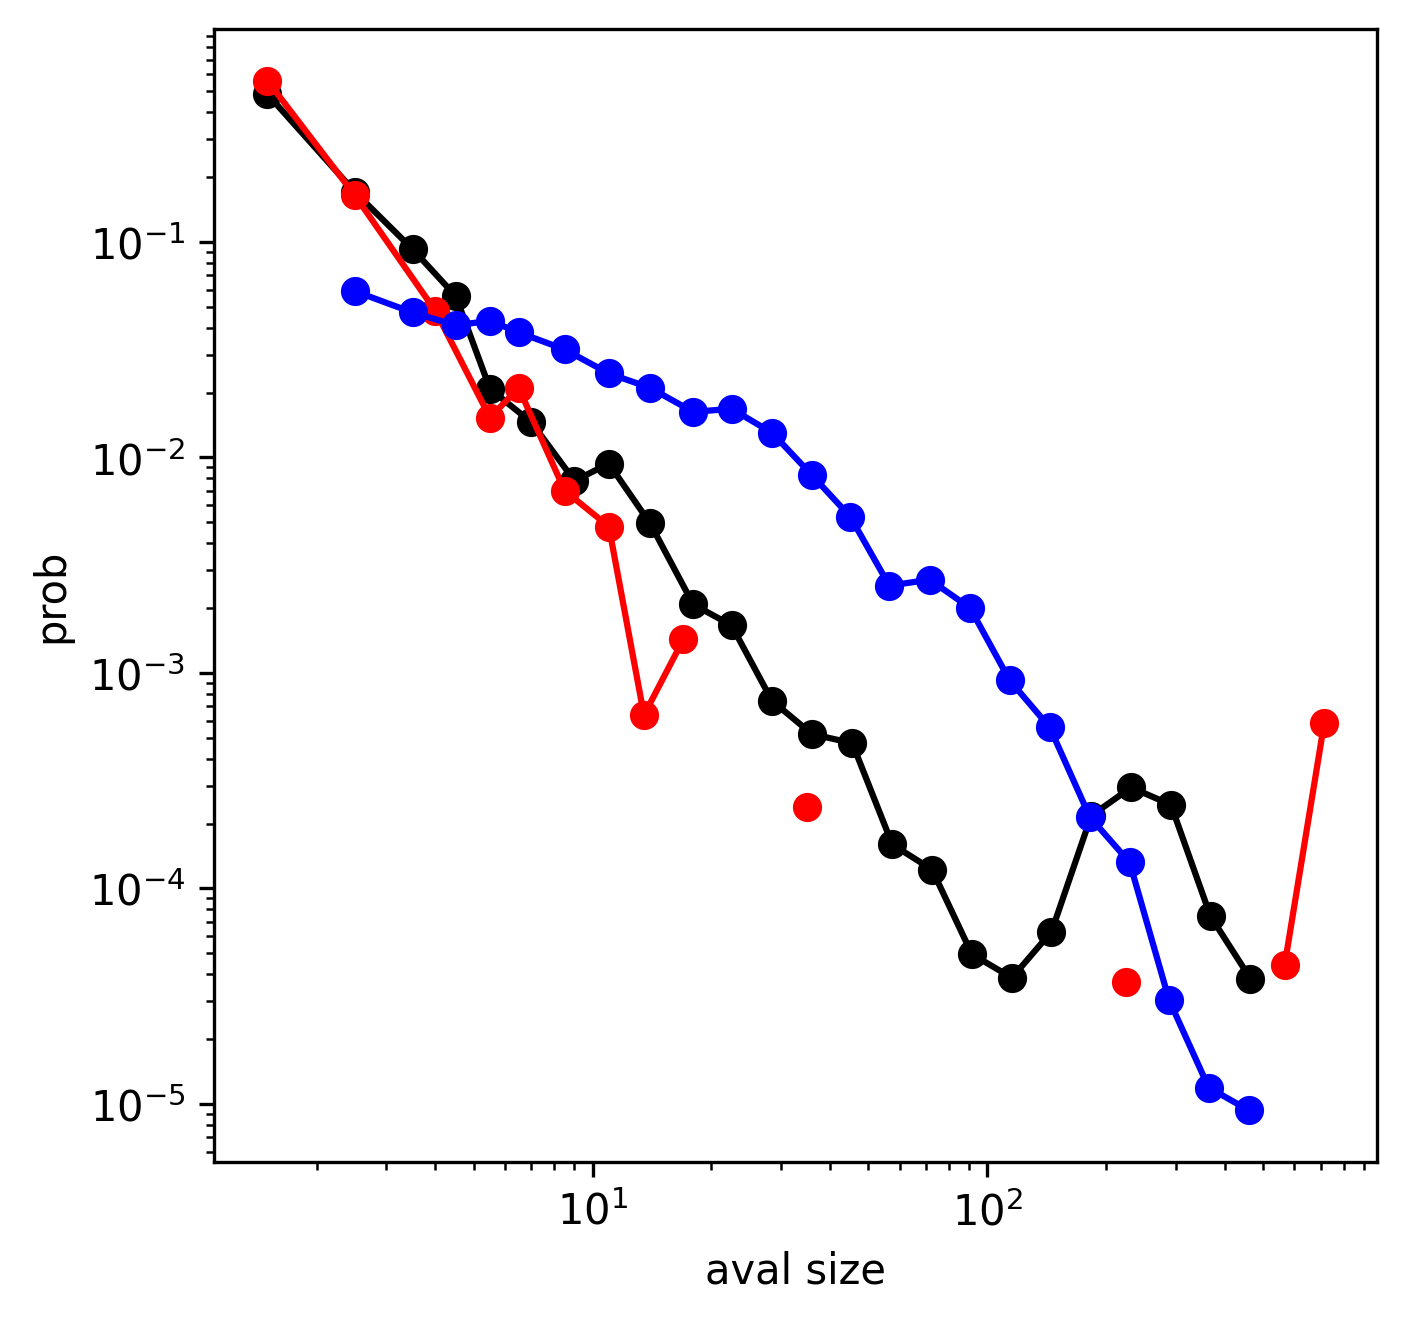

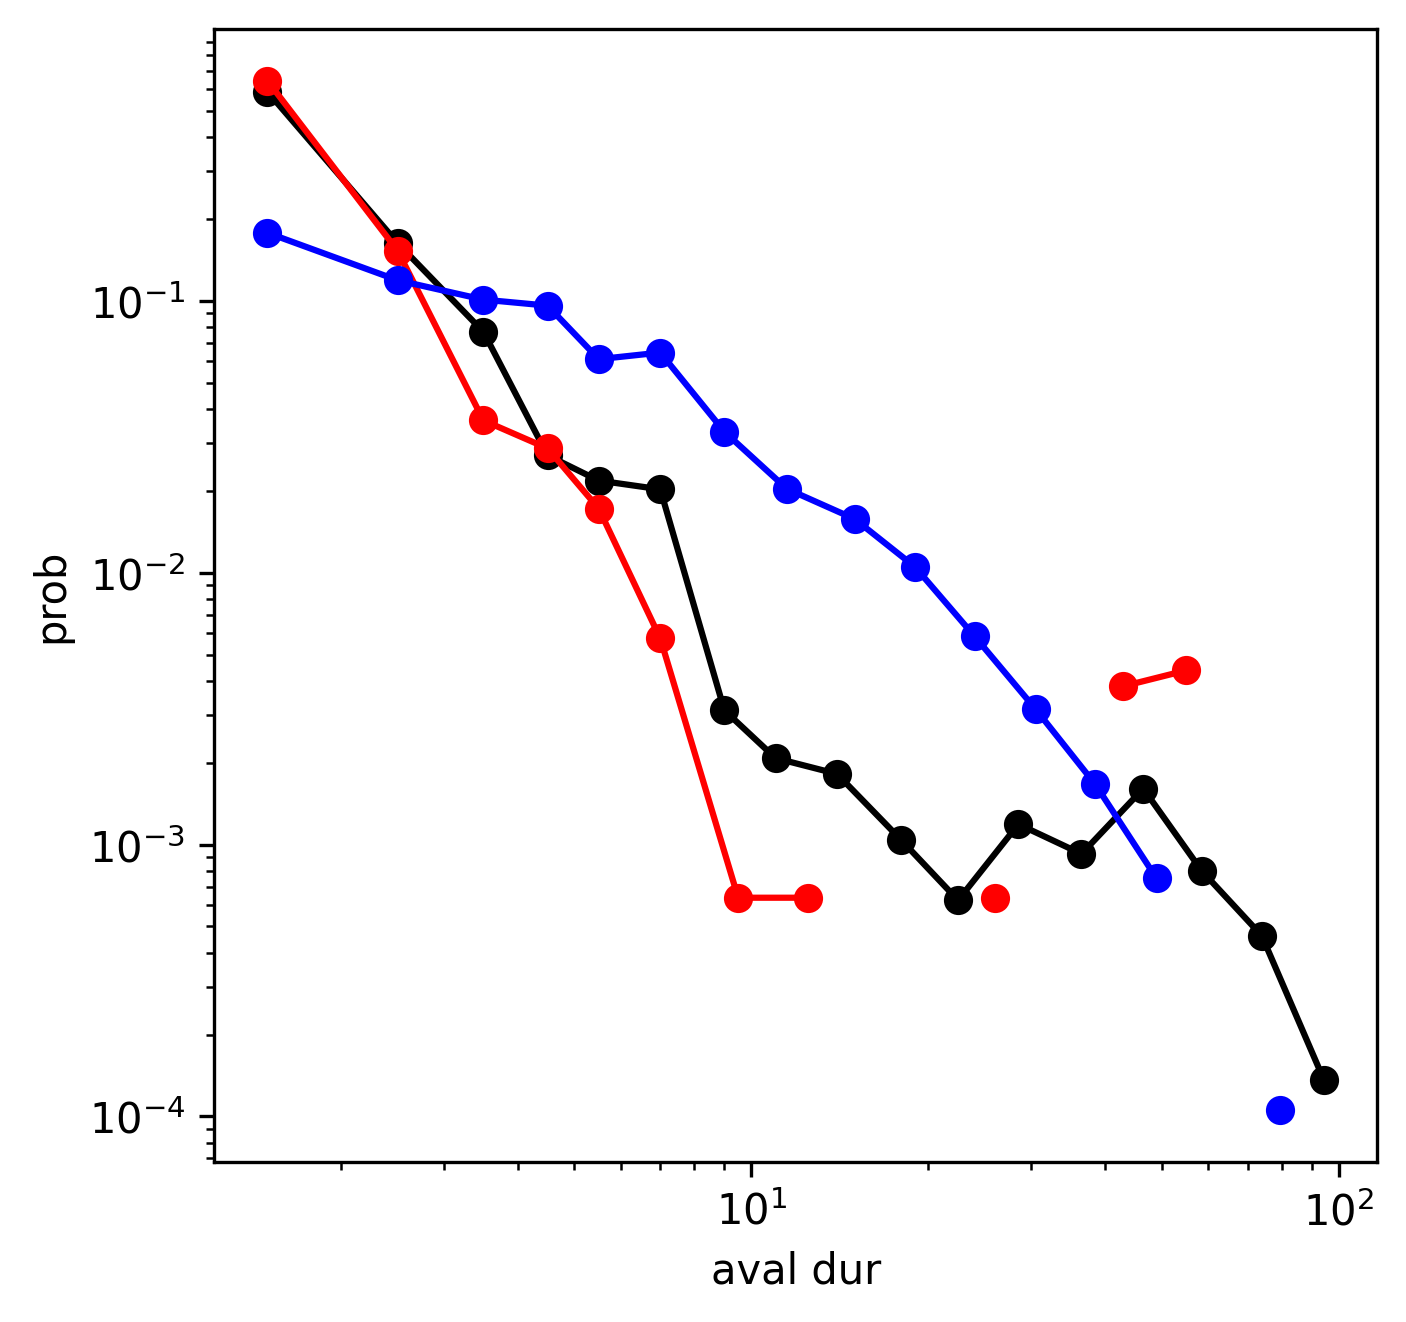

In [20]:
super_spike = np.load("supercritical_spike.npy")
sub_spike = np.load("subcritical_spike.npy")
critical_spike = np.load("critical_spike.npy")

fig1 = plt.figure(figsize=(5, 5), dpi=300)
ax1 = fig1.gca()
fig2 = plt.figure(figsize=(5, 5), dpi=300)
ax2 = fig2.gca()
_, aval_size, aval_dur, _ = compute_avalanche(critical_spike)
fit = powerlaw.Fit(aval_size, xmin=aval_size.min(), xmax=aval_size.max())
fit.plot_pdf(ax=ax1, original_data=False, c="k", marker='o',linestyle='-')  #  marker='o',
fit = powerlaw.Fit(aval_dur, xmin=aval_dur.min(), xmax=aval_dur.max())
fit.plot_pdf(ax=ax2, original_data=False, c="k", marker='o', linestyle='-')

threshold = np.median(np.sum(super_spike, axis=1)) / 2
print("threshold," ,threshold)
_, aval_size, aval_dur, _ = compute_avalanche(super_spike, threshold=None)
fit = powerlaw.Fit(aval_size, xmin=aval_size.min())
fit.plot_pdf(ax=ax1, original_data=False,  c="r",marker='o', linestyle='-')
fit = powerlaw.Fit(aval_dur, xmin=aval_dur.min())
fit.plot_pdf(ax=ax2, original_data=False, c="r", marker='o', linestyle='-')

_, aval_size, aval_dur, _ = compute_avalanche(sub_spike, threshold=None)
fit = powerlaw.Fit(aval_size, xmin=aval_size.min(), xmax=aval_size.max())
fit.plot_pdf(ax=ax1, original_data=False, c="b", marker='o',linestyle='-')
fit = powerlaw.Fit(aval_dur, xmin=aval_dur.min(), xmax=aval_size.max())
fit.plot_pdf(ax=ax2, original_data=False, c="b", marker='o', linestyle='-')
ax1.set_xlabel("aval size")
ax1.set_ylabel("prob")

ax2.set_xlabel("aval dur")
ax2.set_ylabel("prob")
fig1.savefig("./aval_size.eps")
fig2.savefig("./aval_dur.eps")